# LangGraphについて

* LangGraphでは、各ノードが特定の処理や判断を担当し、エッジがそれらの処理間のつながりや関係性を表す

## 特徴
1. 明示的なステート管理
    * LangGraphでは、システムの「ステート（状態）」を明示的に定義し、管理できる。ステートは、会話の履歴、収集した情報、中間結果などを含む構造化されたデータとして表現される。各ノードはこのステートを入力として受け取り、処理を行った後、ステートを更新する。これにより、長期的なタスクや複数のステップを要する処理において、一貫性のある情報の受け渡しと更新が可能になる。
2. 条件分岐とループの自然な処理
    * グラフ構造を用いることで、「もし～なら」という条件分岐や、「～になるまで繰り返す」というループ処理を直感的に表現できる。これにより、複雑な意思決定プロセスを持つシステムの実装が容易になる。
3. 段階的な拡張性
    * 新しい機能を追加したい場合、既存のグラフ構造に新しいノードを追加し、適切なエッジで接続するだけで済む。これにより、システムの段階的な拡張が容易になる。
4. デバッグとテストの容易さ
    * 各ノードを独立してテストできるため、システムのデバッグやテストが容易になる。また、LangSmithと組み合わせることによりグラフ単位での処理のトレースが可能になるため、問題が発生した箇所を特定しやすくなる。
5. チェックポイントとリカバリ
   * LangGraphはステートのチェックポイントを作成し、保存する機能を提供する。これにより、長時間実行されるタスクを中断し、あとで再開したり、エラーが発生した場合に特定のポイントから処理を再開したりすることが可能になる。
  
## LangGraphの主要コンポーネント

LLMを活用したQ&AアプリをLangGraphで開発  
サンプルフロー:  

1. ユーザーが質問を投げる
2. 質問を分類し、回答作成担当のロールを選定する
3. 回答作成担当のロールが回答を作成する
4. 作成された回答の品質チェックを行う。問題がある場合は、2. のステップに戻り、再度質問を分類する
5. 回答をユーザーに提示する

### ステート：グラフの状態を表現
* ステート：各ノードによって更新された値を保存するための仕組み。各ノードは、このステートに保存されているデータを読み書きしながら処理を進める。そのため、LangGraphによる実装を進めるときは、まずどのようなデータ構造でデータを保存する必要があるかを設計する必要がある。
* LangGraphでは、ステートのデータ構造を**TypeDict**クラス、もしくはPydanticの**BaseModel**クラスを用いて定義する。各ノードによる処理の前に、これらのクラスのインスタンスが常に現在のステートとして渡される。各ノードはこのステートを参照して処理を行い、処理結果によってステートを更新し、処理を終了する。
* ステートの各フィールド（クラスの属性）では、更新時のオペレーションをアノテーション(typing.Annotated)を用いて明示的に指定することができる。デフォルトでは**set**オペレーションが使用され、フィールドに対応する値が上書きされる。
* 一方、リストや辞書などの値に対して要素を追加していきたい場合は、**add**オペレーションを指定する。

#### 例：
```python
import operator
from typing import Annotated

from langchain_core.pydantic_v1 import BaseModel, Field

class State(BaseModel):
    query: str=Field(
        ..., description="ユーザーからの質問"
    )
    current_role: Field(
    default="", description="選定された回答ロール"
    )
    message: Annotated[list[str], operator.add]=Field(
    default=[], description="品質チェックの結果"
    )
    judgement_reason: str=Field(
    default="", description="品質チェックの判定理由"
    )
```
* ここでは、messageフィールドにAnnotatedとoperator.addを定義している。これにより、messageフィールドが文字列のリストであること、そして、ステートの更新時にはaddオペレーション（リストに要素を追加）行われることを意味する。
* 一方、current_roleフィールドは通常の文字列で、ステートの更新時にはsetオペレーション（値の上書き）が行われる。
* グラフのステートについて型定義ができたら、StateGraphクラスにその定義を渡し、グラフのインスタンスを作成する。StateGraphクラスはLangGraphにおけるグラフ構造の定義のために使われるクラスで、ワークフローを構成するノードやエッジを管理する役割を担う。
```python
from langgraph.graph import StateGraph

work_flow = StateGraph(State)
```

* このようにして作られたグラフのインスタンスは、アプリのステートを管理するコンテナのような役割を果たす。

### ノード：グラフを構成する処理の単位
* グラフを構成するノードは、StateGraphクラスのadd_node関数を使って追加する。

#### ノードの指定方法
* ノードの指定方法は２種類ある。関数またはRunnable(LCELのオブジェクト)のみを指定する方法と、ノード名(文字列)と関数またはRunnableのペアを指定する方法。

```python
# 関数またはRunnableのみを指定する例
# この場合のノード名は、"answering_node"になる
workflow.add_node(answering_node)
```
* この例の場合は、関数名がノード名として暗黙に扱われる。
* ノード名を別の名前にしたいか、明示したい場合は、次のように記述する必要がある。
```python
# anseringという名前のノードを定義
# ノード内の処理はanswering_node関数が行う
workflow.add_node("answering", answering_node)
```

#### ノードの実装方法
* ノードに関数を渡す場合は、ステートオブジェクトを引数に取り、更新差分を表す辞書型のオブジェクトを返すように実装する。たとえば、ユーザーからの質問内容と選択されたロールをもとに回答を生成するノードの実装は以下のようになる。
```python
from typing import Any

def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role

    # ユーザーからの質問内容と選択されたロールをもとに回答を生成するロジック
    generated_message = # ...生成処理...

    # 生成された回答でステートを更新
    return {"messages": [generated_message]}
```

* ここでは、ステートからquery（ユーザーからの質問内容）とrole（選定されたロール）を取り出し、それに基づいて回答を生成する。
* generated_message（生成された回答）はmessagesフィールドのリストに追加するために、\[generated_message]といった形に、リスト型で返す。

<br>

* add_nodeの第２引数にRunnableを渡す場合も、関数と同様にステートを受け取って更新差分を返す実装にする。たとえば、answering_nodeをLCELを用いて実装しなおす場合は、次のようになる。
```python
prompt = # ... queryとroleを引数に取るChatPromptTemplate
llm = # ... LangChainのChat model

answering_node = (
    RunnablePassthrough.assing(
        query=lambda state: state.query,
        role=lambda sate: state.role
    )
    | prompt
    | llm
    | StrOutputParser()
    | RunnablePasssthrough.assing(
        messages=lambda x: [x]
    )
)
```

<br>

* また、複数のフィールドを更新する場合は、複数のフィールド名と対応するキーに値を設定した辞書型のオブジェクトを返す。例えば、回答の品質チェックノードにおいて、current_judgeフィールド（品質チェックの結果）とjudgement_reasonフィールド（品質チェックの判定理由）を同時に更新するケースでは次のように実装する。
```python
def check_node(state: State) -> dict[str, Any]:
    query = state.query
    message = state.messages[-1]

    # ユーザーからの質問内容と回答内容から品質チェックを行う処理
    judge = # ... 判定理由 ...
    reason = # ... 理由の生成 ...

    # 生成された回答でステートを更新
    return {"current_judge": judge, "judgement_reason": reason}
```
* このようにノードの処理では、ステートから必要な情報を取り出し、処理結果をもとにステートを更新するための辞書型のオブジェクトを返す。


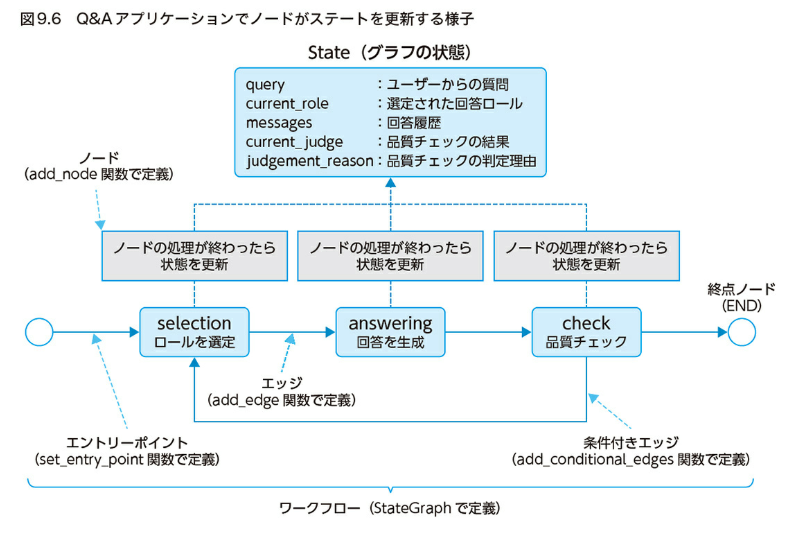

In [2]:
from PIL import Image
im = Image.open("./data/state_photo.png")
im

### エッジ：ノード間の接続
* ノードを定義したあとは、それらノード間の接続関係を「エッジ」で定義する。LangGraphには３種類のエッジがある。

#### 1. エントリーポイント
* グラフの開始ノードを指定するエッジ。set_entry_point関数で開始ノートとなるノード名を文字列で指定する。
```python
workflow.set_entry_point("selection")
```

#### 2. エッジ
* あるノードから別のノードに無条件で繊維するエッジ。add_edge関数で設定する。第１引数に遷移元ノード名、第２引数に遷移先ノード名をそれぞれ文字列で指定する。
```python
# selectionノードからansweringノードにエッジを張る
workflow.add_edge("selection", "answering")
```

#### 3. 条件付きエッジ
* 条件に基づいて遷移先のノードを決定するエッジ。add_condition_edges関数で設定する。第１引数に遷移元ノード名を文字列で指定し、第２引数に何らかの値を返す関数を設定する。第３引数には第２引数で返される値に対応する遷移先ノード名とのマッピングを、辞書型のオブジェクトとして設定する。
* 以下コードでは、state.current_judgeの値がTrueの場合は終点ノードを表すEND、falseの場合はselectionノードに遷移することを表している。ENDは終点ノードを表すためのLangGraphにおける組み込み定数。
```python
from langgraph.graph import END

# checkノードからエッジを張る
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)
```

### コンパイル済みグラフ
* 定義したグラフはcompile関数によって、実行可能なCompiledGraphのインスタンスへと変換される。
```python
compiled = workflow.compile()
```

* CompiledGraphクラスのインスタンスはRunnableとして実行できる。そのため、invoke関数やstream関数といった関数を利用して、定義したグラフを実行することが可能。

#### invoke関数（同期実行）
* グラフ内のすべての処理が実行されてから最終的な値が返却される。
```python
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)
```

#### ainvoke関数（非同期実行）
```python
initial_state = State(query="生成AIについて教えてください")
result = await compiled_ainvoke(initial_state)
```

#### stream関数
* ノード実行時のステートを逐次的に取得できる
```python
initial_state = State(query="生成AIについて教えてください")
for step in compiled.stream(initial_state):
    print(step)
```

# Pydanticについて

Pydantic は **「Python の型ヒントを“実行時スキーマ”に変換し、入力を自動で検証・変換してくれるデータモデルライブラリ」** です。LangChain では LLM から返ってくる JSON を安全に構造化したり、ツール／エージェントに渡す引数のスキーマを宣言したりする場面で、LangGraph ではグラフの **state** を型安全に扱うために広く使われています。以下では、Pydantic の基礎から LangChain／LangGraph での具体的な利用例まで順を追って解説します。

---

## 1. Pydantic とは何か

### 1.1 コアアイデア

* 型ヒント付きクラス `BaseModel` を宣言すると、Pydantic が **パーサ＋バリデータ** を自動生成し、入力を正しい型に変換しながらインスタンスを構築します。([docs.pydantic.dev][1])
* v2 系は Rust 製エンジン **pydantic-core** を採用し、JSON バリデーションで 10～50 倍高速化しています。([pydantic.dev][2])

### 1.2 主な機能

| 機能                   | 説明                                                                                              |
| -------------------- | ----------------------------------------------------------------------------------------------- |
| **型変換 & バリデーション**    | 文字列 `"123"` → `int` など自動キャストし、失敗時は詳細なエラーメッセージを返す。([realpython.com][3])                          |
| **JSON/Dict との相互変換** | `.model_dump()` / `.model_validate_json()` で高速シリアライズ／デシリアライズ。([docs.pydantic.dev][4])           |
| **スキーマ生成**           | `model.model_json_schema()` で JSON Schema / OpenAPI を自動生成。SDK 生成にも活用可能。([docs.pydantic.dev][5]) |
| **環境変数設定**           | `BaseSettings` を継承すれば `.env` 読み込みや型変換付き設定管理に。([docs.pydantic.dev][1])                           |
| **カスタム validator**   | `@field_validator` で複雑な制約も宣言的に記述。([docs.pydantic.dev][6])                                       |

---

## 2. 基本の使い方

```python
from pydantic import BaseModel, Field, ValidationError

class User(BaseModel):
    id: int
    name: str = Field(..., min_length=2)
    email: str

try:
    user = User(id="123", name="Al", email="alice@example.com")
    print(user.model_dump())           # ⇒ {'id': 123, 'name': 'Al', 'email': 'alice@example.com'}
except ValidationError as e:
    print(e.json())                    # バリデーションエラーは JSON でも取得可
```

* 文字列 `"123"` が `int` に変換され、長さ 2 以上の `name` が保証されます。([realpython.com][3])
* `.model_dump(mode="json")` で JSON 対応の辞書へ安全にシリアライズ。([docs.pydantic.dev][4])

---

## 3. Pydantic を LangChain で使う

### 3.1 LLM から構造化データを受け取る

```python
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel

class StockQuote(BaseModel):
    symbol: str
    price: float

prompt = ChatPromptTemplate.from_template(
    "銘柄 {symbol} の現在値を JSON で返してください"
)

llm = ChatOpenAI(model="gpt-4o-mini")

chain = prompt | llm.with_structured_output(StockQuote) | StrOutputParser()
quote: StockQuote = chain.invoke({"symbol": "AAPL"})
```

* `with_structured_output()` は **モデル → Pydantic** を自動ラップし、JSON 文字列を `StockQuote` に変換・検証します。([python.langchain.com][7])
* バリデーションに失敗するとエラーが上がるため、エージェントの信頼性が向上します。

### 3.2 LangChain Tools / Agents での引数スキーマ

```python
from langchain_core.tools import tool

class WeatherArgs(BaseModel):
    city: str
    unit: str = "metric"

@tool(args_schema=WeatherArgs)
def get_weather(city: str, unit: str):
    ...
```

* LLM は **ツールの docstring + Pydantic スキーマ** を読んで適切な引数 JSON を生成し、LangChain が検証してから関数を実行します。([python.langchain.com][8])

---

## 4. Pydantic を LangGraph で使う

LangGraph の状態 (`state_schema`) は **TypedDict / dataclass / Pydantic** のいずれかで定義できます。Pydantic を採用すると、各ノードが状態を更新するたびに自動で型検査が走り、バグを早期検知できます。([langchain-ai.github.io][9])

```python
from langgraph.graph import StateGraph
from pydantic import BaseModel

class ChatState(BaseModel):
    history: str

graph = StateGraph(state_schema=ChatState)
```

* ノード実装で `state.history += user_msg` のような更新を行うと、常に `str` であることが保証されます。([langchain-ai.github.io][10])

---

## 5. より進んだ活用テクニック

### 5.1 OpenAPI スキーマ生成と SDK 連携

`model_json_schema()` を API ドキュメント化やクライアント生成に流用可能。OpenAPI → Pydantic のコード生成も `datamodel-code-generator` が対応。([speakeasy.com][11])

### 5.2 高速パース

v2 では `model_validate_json()` が推奨。JSON 文字列を直接 Rust バックエンドで検証・構築し、従来より最大 20 倍高速。([docs.pydantic.dev][12])

### 5.3 Settings 管理

LangChain/LLM アプリで API キーやモデル名を安全にロード・検証できる。

```python
class AppSettings(BaseSettings):
    openai_api_key: str
    model_name: str = "gpt-4o-mini"
settings = AppSettings()               # .env から取得
```

---

## 6. まとめ

* **Pydantic = 型ヒント × 実行時バリデーション／変換**。
* `BaseModel` を継承してフィールドを宣言 → 自動で JSON との相互変換、詳細エラーレポート、OpenAPI スキーマ生成が可能。
* **LangChain** では `with_structured_output` やツールの `args_schema` で出力／入力を安全に型付け。
* **LangGraph** では `state_schema` に使ってグラフ全体の状態整合性を保証。
* v2 系は Rust エンジンで高速化・エラー表現改善、`model_validate_json` 推奨。

Pydantic を活用することで、LLM システムの入出力を **型安全・高速・自己説明的** に保ちながら開発できるようになります。

[1]: https://docs.pydantic.dev/1.10/usage/models/?utm_source=chatgpt.com "Models - Pydantic"
[2]: https://pydantic.dev/articles/pydantic-v2-7-release?utm_source=chatgpt.com "New Features and Performance Improvements in Pydantic v2.7"
[3]: https://realpython.com/python-pydantic/?utm_source=chatgpt.com "Pydantic: Simplifying Data Validation in Python"
[4]: https://docs.pydantic.dev/latest/concepts/json/?utm_source=chatgpt.com "JSON - Pydantic"
[5]: https://docs.pydantic.dev/latest/integrations/datamodel_code_generator/?utm_source=chatgpt.com "datamodel-code-generator - Pydantic"
[6]: https://docs.pydantic.dev/latest/concepts/validators/?utm_source=chatgpt.com "Validators - Pydantic"
[7]: https://python.langchain.com/docs/how_to/structured_output/?utm_source=chatgpt.com "How to return structured data from a model - Python LangChain"
[8]: https://python.langchain.com/docs/concepts/structured_outputs/?utm_source=chatgpt.com "Structured outputs - Python LangChain"
[9]: https://langchain-ai.github.io/langgraph/how-tos/state-model/?utm_source=chatgpt.com "How to use Pydantic model as graph state - GitHub Pages"
[10]: https://langchain-ai.github.io/langgraph/how-tos/graph-api/?utm_source=chatgpt.com "Use the Graph API - GitHub Pages"
[11]: https://www.speakeasy.com/openapi/frameworks/pydantic?utm_source=chatgpt.com "How To Generate an OpenAPI Spec with Pydantic V2 - Speakeasy"
[12]: https://docs.pydantic.dev/latest/concepts/performance/?utm_source=chatgpt.com "Performance - Pydantic"


# pydanticで使っている、Annotated、 operatorについて

Pydantic は「**型ヒントで宣言したクラス**をそのまま **実行時スキーマ** として扱い、入力データを自動で検証・型変換してくれるライブラリ」です。Python 3.8 以降の標準型ヒントとよく統合されており、LangChain / LangGraph では (1) LLM 出力を安全に構造化する、(2) ツールやエージェントの引数スキーマを宣言する、(3) グラフ状態 (state) の整合性を保つ、といった目的で多用されます。([github.com][1], [docs.pydantic.dev][2])

## 1 Pydantic `BaseModel` と `Field`

### 基本構文

```python
from pydantic import BaseModel, Field

class User(BaseModel):
    id: int
    name: str = Field(..., min_length=2)
```

* `BaseModel` を継承して属性に型を付けるだけで **バリデーション・型変換** が得られます。([github.com][1])
* `Field()` にはデフォルト値、説明、制約 (min\_length 等) を付加でき、JSON Schema も自動生成されます。([docs.pydantic.dev][2])

### 実行例

```python
user = User(id="123", name="Alice")
# id は str→int にキャストされる
```

型が合わない場合は `ValidationError` が投げられます。([stackoverflow.com][3])

## 2 `typing.Annotated` とは

Python 3.9+ の `typing.Annotated` は「**型に追加メタデータを重ねる**」ための仕組みで、Pydantic v2 では主に

* **フィールド制約やバリデータを型側に埋め込む**
* **LangGraph の state にリデューサー（集約関数）を指定する**
  という用途に使います。([stackoverflow.com][4])

```python
from typing import Annotated
from pydantic import BaseModel, Field, AfterValidator

PositiveInt = Annotated[int, Field(gt=0)]

class Item(BaseModel):
    count: PositiveInt         # 0以下だと ValidationError
```

Pydantic は Annotated の 2 番目以降の引数（ここでは `Field(gt=0)`）を拾って検証します。([docs.pydantic.dev][5])

## 3 `operator` モジュールとリデューサー

`operator` は Python 組み込みの演算子関数セットです。`operator.add(x, y)` は `x + y` 相当です。リストの場合「結合」動作になるため **LangGraph が並列ノードから来た値をマージする関数**としてちょうど良い、というわけです。([reddit.com][6])

### LangGraph の state での典型パターン

```python
from typing import Annotated
import operator
from langgraph.graph import StateGraph

class ChatState(BaseModel):
    messages: Annotated[list[str], operator.add]   # ← reducer
    current_role: str = ""
```

* `Annotated[list[str], operator.add]` と宣言すると、**複数ノードが同じ `messages` キーに値を返したとき** LangGraph は `operator.add` を使ってリストを **結合** します。([langchain-ai.github.io][7], [medium.com][8])
* カスタムリデューサーも渡せます（重複除去や最新優先など）。([github.com][9])

## 4 質問コードの解説

```python
class State(BaseModel):
    query: str = Field(..., description="ユーザーからの質問")
    current_role: str = Field(default="", description="選定された回答ロール")
    message: Annotated[list[str], operator.add] = Field(
        default=[], description="品質チェックの結果"
    )
    judgement_reason: str = Field(default="", description="品質チェックの判定理由")
```

| フィールド              | 型                | 意味       | Annotated / operator の効果                                                              |
| ------------------ | ---------------- | -------- | ------------------------------------------------------------------------------------- |
| `query`            | `str`            | ユーザークエリ  | 必須 (`...`) なので欠けるとエラー                                                                 |
| `current_role`     | `str`            | 現在選択中の役割 | 空文字をデフォルト                                                                             |
| `message`          | `list[str]` (集約) | 品質チェックログ | `Annotated[..., operator.add]` により **並列処理で返った複数のログを連結** ([langchain-ai.github.io][7]) |
| `judgement_reason` | `str`            | 判定理由     | デフォルト空文字                                                                              |

これを state\_schema に指定して `StateGraph` を作ると、LangGraph は

1. 各ノードが `return {"message": ["○○"]}` のように出したとき
2. 同じステップで複数値が集まっても `operator.add` で結合し、`message` リストが伸びる

という振る舞いを行います。([reddit.com][6])

## 5 LangChain / LangGraph での実用例

### LangChain で構造化出力

```python
class AnswerWithScore(BaseModel):
    answer: str
    score: float

chain = prompt | llm.with_structured_output(AnswerWithScore)
result: AnswerWithScore = chain.invoke({"context": "...", "question": "..."})
```

LLM が返す JSON を `AnswerWithScore` にパース・検証します。([docs.pydantic.dev][2])

### LangGraph でチャット履歴を蓄積

```python
class ChatState(BaseModel):
    messages: Annotated[list[str], operator.add]

graph = StateGraph(state_schema=ChatState)
# 各ノードは {'messages': [new_msg]} を返す。履歴は自動で追加される
```

並列ノードでも履歴が壊れず一つにまとまります。([shuaiguo.medium.com][10], [medium.com][11])

---

## 6 まとめ

* **Pydantic**: タイプヒント → 実行時スキーマ。`Field()` で制約を追加、エラーは `ValidationError`。([github.com][1])
* **`Annotated`**: 型に **追加メタ情報** を付与。Pydantic はここから制約やリデューサーを読み取る。([stackoverflow.com][4])
* **`operator.add`**: Python 標準ライブラリの “+” 演算を関数として提供。LangGraph のリデューサーに渡すとリストを結合できる。([reddit.com][6])
* LangChain では **LLM 出力の構造化**、LangGraph では **state の型付け＋マージ戦略** に広く利用。 ([langchain-ai.github.io][7], [blog.langchain.dev][12])

これらを理解すると、LLM アプリ開発で「**型安全**」「**並列マージ**」「**堅牢な入力検証**」を一気に手に入れられるようになります。

[1]: https://github.com/pydantic/pydantic/discussions/8842?utm_source=chatgpt.com "How to convert a PydanticV2 model into a V1 one? #8842 - GitHub"
[2]: https://docs.pydantic.dev/latest/concepts/fields/?utm_source=chatgpt.com "Fields - Pydantic"
[3]: https://stackoverflow.com/questions/75018324/what-is-the-difference-between-pydantic-field-and-annotated?utm_source=chatgpt.com "What is the difference between pydantic Field and Annotated?"
[4]: https://stackoverflow.com/questions/71898644/how-to-use-python-typing-annotated?utm_source=chatgpt.com "How to use python typing.Annotated - Stack Overflow"
[5]: https://docs.pydantic.dev/2.8/concepts/validators/?utm_source=chatgpt.com "Validators - Pydantic"
[6]: https://www.reddit.com/r/LangChain/comments/1hxt5t7/help_me_understand_state_reducers_in_langgraph/?utm_source=chatgpt.com "Help Me Understand State Reducers in LangGraph - Reddit"
[7]: https://langchain-ai.github.io/langgraph/reference/graphs/?utm_source=chatgpt.com "Graphs"
[8]: https://medium.com/%40vamsikd219/beginners-guide-to-langgraph-create-a-multi-agent-assistant-with-llama-3-ab51c8acd0a1?utm_source=chatgpt.com "Beginner's Guide to LangGraph: Create a Multi-Agent Assistant with ..."
[9]: https://github.com/langchain-ai/langgraph/discussions/2730?utm_source=chatgpt.com "How to pass state that uses add operator to subgraph without ..."
[10]: https://shuaiguo.medium.com/langgraph-101-lets-build-a-deep-research-agent-with-gemini-228b50076269?utm_source=chatgpt.com "LangGraph 101: Let's Build A Deep Research Agent with Gemini"
[11]: https://medium.com/%40danushidk507/ai-agents-xii-langgraph-graph-based-framework-b7b74e1fa5df?utm_source=chatgpt.com "AI Agents XII — LangGraph graph-based framework - Medium"
[12]: https://blog.langchain.dev/langgraph/?utm_source=chatgpt.com "LangGraph - LangChain Blog"
